In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rrcf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read csv file
df_turbidity = pd.read_csv("node2_data_latest.csv")
print('The number of samples of the data ', len(df_turbidity))
df_turbidity.head()

The number of samples of the data  2658


,time,turbidity,pH
0,2020-11-04 11:00:31.822439+00:00,21.063435,7.34
1,2020-11-04 11:01:22.124333+00:00,20.868153,7.33
2,2020-11-04 11:01:51.663062+00:00,20.584553,7.32
3,2020-11-04 11:02:29.373718+00:00,21.185328,7.33
4,2020-11-04 11:03:45.517010+00:00,21.063435,7.32


In [3]:
# Convert dataframe to array
turbidity_train= np.array(df_turbidity['turbidity'])

In [4]:
# Set tree parameters
num_trees = 40
shingle_size = 1
tree_size = 256


In [5]:
# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)


In [6]:
# Use the "shingle" generator to create rolling window
points = rrcf.shingle(turbidity_train, size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

In [7]:
%%time
# Display prediction result

for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size, drop the oldest point
        # (FIFO)
        if len(tree.leaves) > tree_size:
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point and take the average among
        # all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees

Wall time: 55.4 s


In [8]:
# Convert score dictionary to data frame.
turbidity_result = pd.DataFrame.from_dict(avg_codisp,'index')

In [9]:
# Merge score with data.
df_turbidity['turbidity'] = turbidity_result

In [10]:
#Try different values of threshold to get anomalies.
anomalies = df_turbidity.loc[df_turbidity['turbidity']>20] # wa 120, changed to 50
anomalies

,time,turbidity,pH
57,2020-11-05 11:28:33.992949+00:00,31.498544,7.35
58,2020-11-05 11:58:50.055242+00:00,25.985764,7.35
61,2020-11-05 13:29:38.182983+00:00,22.234722,7.35
63,2020-11-05 14:30:10.280748+00:00,21.460565,7.36
75,2020-11-05 20:33:22.838949+00:00,20.904861,7.35
...,...,...,...
2630,2021-01-03 19:46:55.508269+00:00,55.800000,7.34
2631,2021-01-03 20:17:11.567674+00:00,29.050000,7.35
2632,2021-01-03 20:47:27.705902+00:00,28.062500,7.35
2634,2021-01-03 21:47:59.749381+00:00,22.981250,7.35


In [11]:
len(anomalies)

288

Text(0.5, 1.0, 'Turbidity data (red) and anomaly score (blue)')

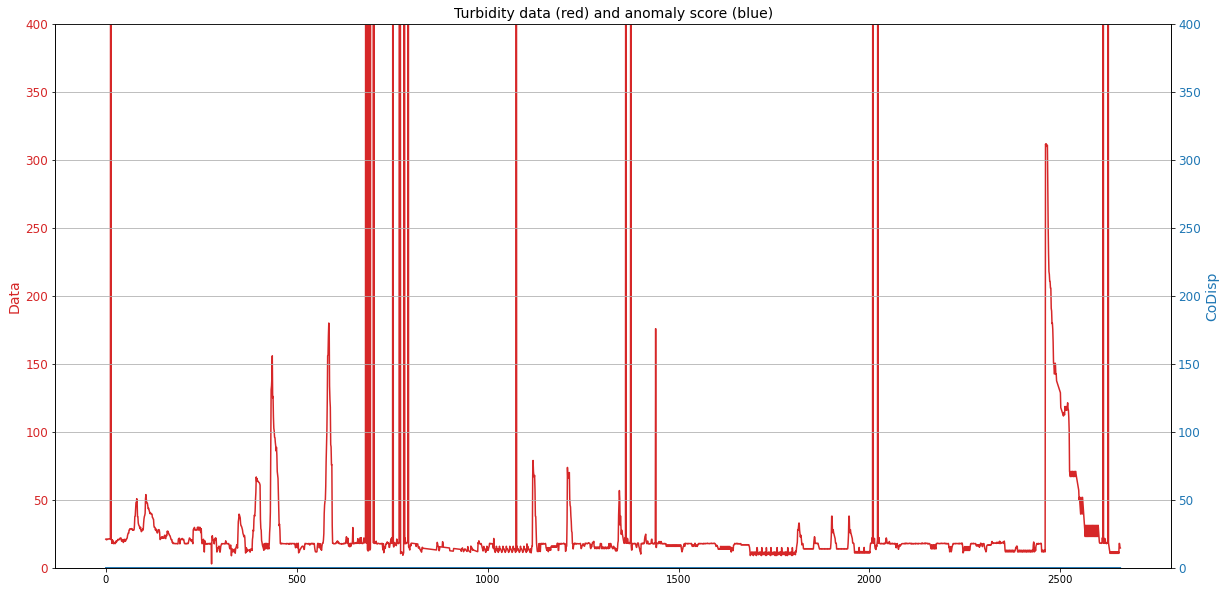

In [21]:
for index in range(len(avg_codisp)):
    avg_codisp[index]=avg_codisp[index]/50
    
fig, ax1 = plt.subplots(figsize=(20, 10))
color = 'tab:red'
ax1.set_ylabel('Data', color=color, size=14)
ax1.plot(turbidity_train, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.set_ylim(0,400)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CoDisp', color=color, size=14)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid('off')
ax2.set_ylim(0,400)
plt.title('Turbidity data (red) and anomaly score (blue)', size=14)

Text(0.5, 1.0, 'Turbidity data (red) and anomaly score (blue)')

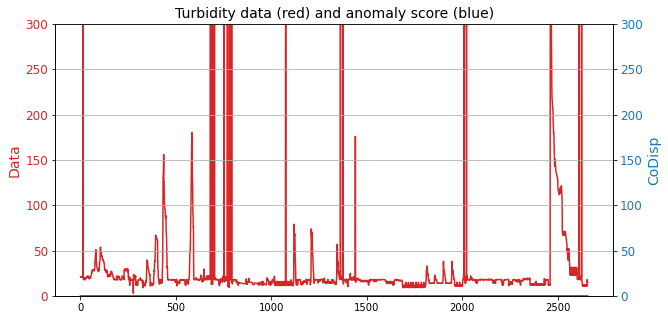

In [20]:
for index in range(len(avg_codisp)):
    avg_codisp[index]=avg_codisp[index]/50
    
fig, ax1 = plt.subplots(figsize=(10, 5))
color = 'tab:red'
ax1.set_ylabel('Data', color=color, size=14)
ax1.plot(turbidity_train, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.set_ylim(0,300)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CoDisp', color=color, size=14)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid('off')
ax2.set_ylim(0,300)
plt.title('Turbidity data (red) and anomaly score (blue)', size=14)

In [14]:
df_anomalies = anomalies

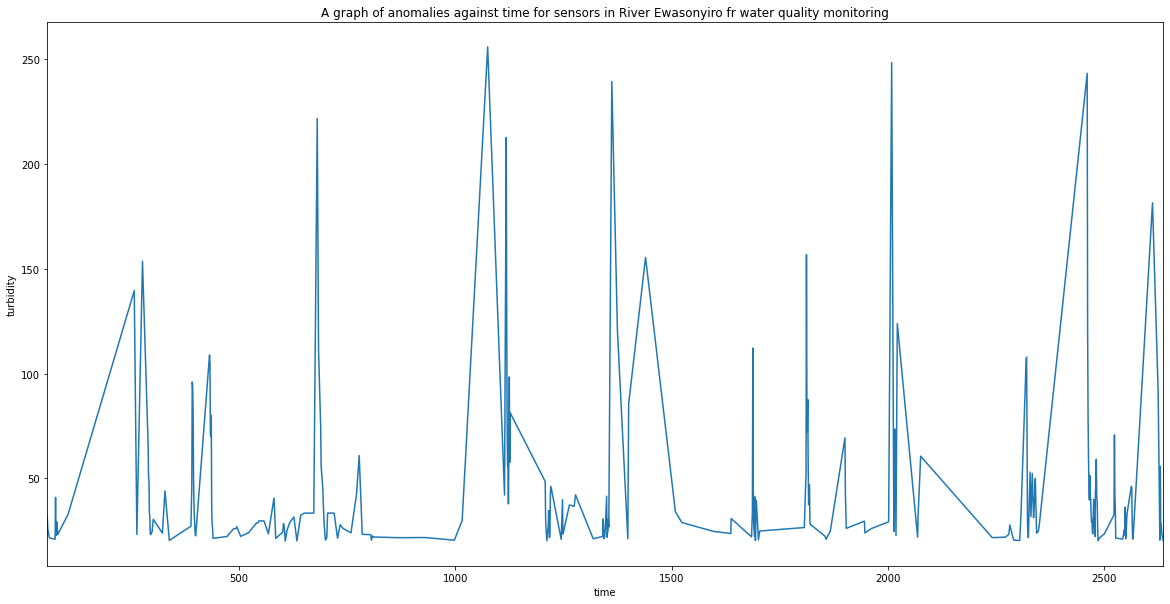

In [15]:
def plot_anomalies_data(df_anomalies, title):
    f1 = plt.figure(figsize =(20, 10))
    df_anomalies['turbidity'].plot( )
    plt.xlabel("time")
    plt.ylabel("turbidity")
    plt.title(title)
    plt.show( )
    
    
plot_anomalies_data(df_anomalies, "A graph of anomalies against time for sensors in River Ewasonyiro fr water quality monitoring")

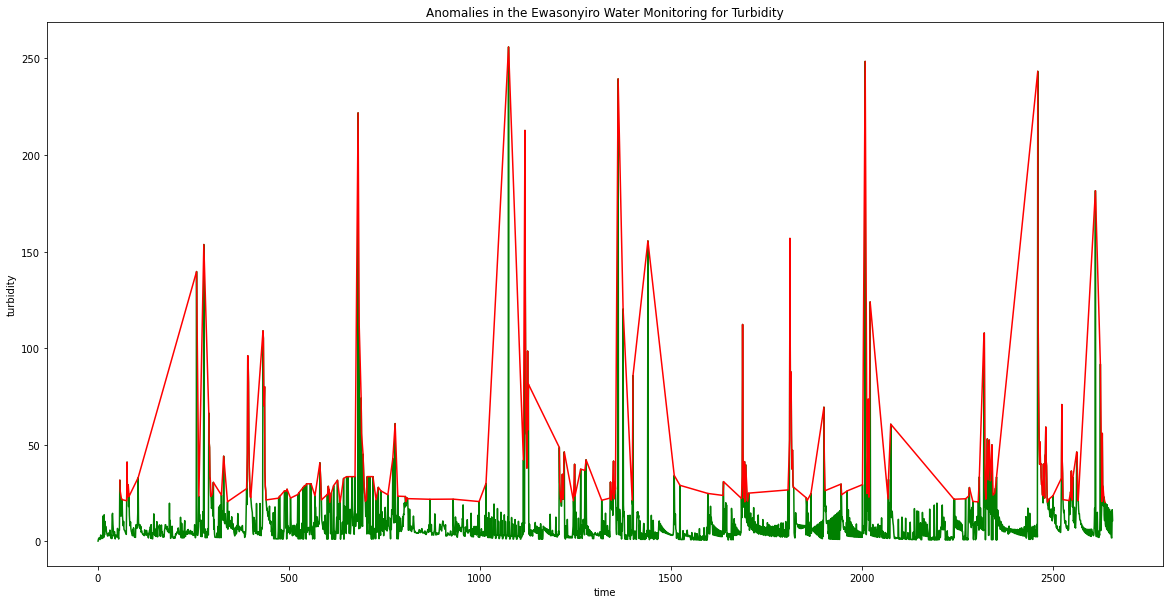

In [16]:
# lets plot the result of LOF anomaly detection
def plot_lof_result(dataset, anomalies, title):
    if 'isinlier' in dataset.columns:
        del dataset['isinlier']
        
    if 'isinlier' in anomalies.columns:
        del anomalies['isinlier']
        
    f2 = plt.figure(figsize =(20, 10))
    plt.plot(dataset['turbidity'], color='green')
    plt.plot(anomalies['turbidity'], "r", markersize =10)
    plt.xlabel("time")
    plt.ylabel("turbidity")
    plt.title(title)
    plt.show()
    
    
plot_lof_result(df_turbidity, df_anomalies , "Anomalies in the Ewasonyiro Water Monitoring for Turbidity")


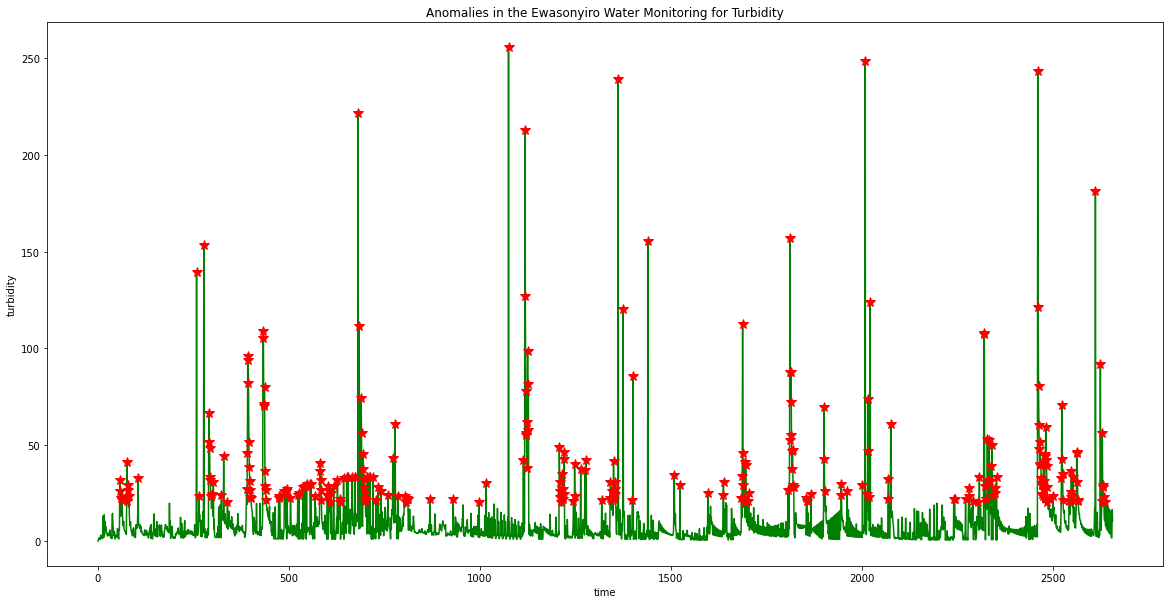

In [18]:
# lets plot the result of LOF anomaly detection
def plot_lof_result(dataset, anomalies, title):
    if 'isinlier' in dataset.columns:
        del dataset['isinlier']
        
    if 'isinlier' in anomalies.columns:
        del anomalies['isinlier']
        
    f2 = plt.figure(figsize =(20, 10))
    plt.plot(dataset['turbidity'], color='green')
    plt.plot(anomalies['turbidity'], "r*", markersize =10)
    plt.xlabel("time")
    plt.ylabel("turbidity")
    plt.title(title)
    plt.show()
    
    
plot_lof_result(df_turbidity, df_anomalies , "Anomalies in the Ewasonyiro Water Monitoring for Turbidity")
